In [ ]:
# Import modules
import pandas as pd
import numpy as np
import time
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn.linear_model as lm
from scipy import stats

***Gather desired data***

*All of the data is sourced from [Natural Stat Trick](https://www.naturalstattrick.com/) which has accessible data tables for previous seasons alongside more advanced team statistics, the postseason data was sourced from [Natural Stat Trick's](https://www.naturalstattrick.com/) playoff filter.*

**[Natural Stat Trick's Glossary](https://www.naturalstattrick.com/glossary.php?teams)**

In [ ]:
def get_regszn_data(year):
    yearstring = str(year-1) + str(year)
    url = "https://www.naturalstattrick.com/teamtable.php?fromseason=" + yearstring + "&thruseason=" + yearstring + "&stype=2&sit=all&score=all&rate=n&team=all&loc=B&gpf=410&fd=&td="
    season_data = pd.read_html(url)
    season_df = season_data[0]
    season_df = season_df.loc[:, ['Team', 'W', 'L', 'OTL', 'Points', 'CF', 'CA', 'CF%', 'SF', 'SA', 'SF%', 'GF', 'GA', 'GF%', 'HDCF', 'HDCA', 'HDCF%', 'HDSV%', 'SV%']]
    season_df['Made_Playoffs'] = False
    season_df['Won_Cup'] = False
    return season_df

In [ ]:
def get_postszn_data(year):
    yearstring = str(year-1) + str(year)
    url = "https://www.naturalstattrick.com/teamtable.php?fromseason=" + yearstring + "&thruseason=" + yearstring + "&stype=3&sit=all&score=all&rate=y&team=all&loc=B&gpf=410&fd=&td="
    postseason_data = pd.read_html(url)
    postseason_df = postseason_data[0]
    postseason_df = postseason_df.loc[:, ['Team', 'GP', 'W', 'L', 'CF/60', 'CA/60', 'CF%', 'SF/60', 'SA/60', 'SF%', 'GF/60', 'GA/60', 'GF%', 'HDCF/60', 'HDCA/60', 'HDCF%', 'HDSV%', 'SV%']]
    postseason_df['Won_Cup'] = False
    postseason_df.loc[postseason_df['W'] >= 16, 'Won_Cup'] = True
    return postseason_df

In [ ]:
# Create years variable for the desired range of seasons
years = range(2010, 2024)
# Create a list of teams that were at the COVID bubble round robins but did not actually qualify for the playoffs
qualifying_losers = ['Winnipeg Jets', 'Minnesota Wild', 'Nashville Predators', 'Edmonton Oilers', 'Toronto Maple Leafs', 'Florida Panthers', 'New York Rangers', 'Pittsburgh Penguins']

In [ ]:
dataframes = {}
for year in years:
    time.sleep(2)
    year_df = get_regszn_data(year)
    postseason_df = get_postszn_data(year)
    year_df['Made_Playoffs'] = year_df['Team'].isin(postseason_df['Team'])
    if year == 2020:
        year_df.loc[year_df['Team'].isin(qualifying_losers), 'Made_Playoffs'] = False
    year_df['Won_Cup'] = year_df['Team'].isin(postseason_df.loc[postseason_df['W'] >= 16, 'Team'])
    dataframes[f'regular_season_data_{year}'] = year_df
    dataframes[f'postseason_data_{year}'] = postseason_df

***Create heatmaps to visualize the correlations between the specified variables***

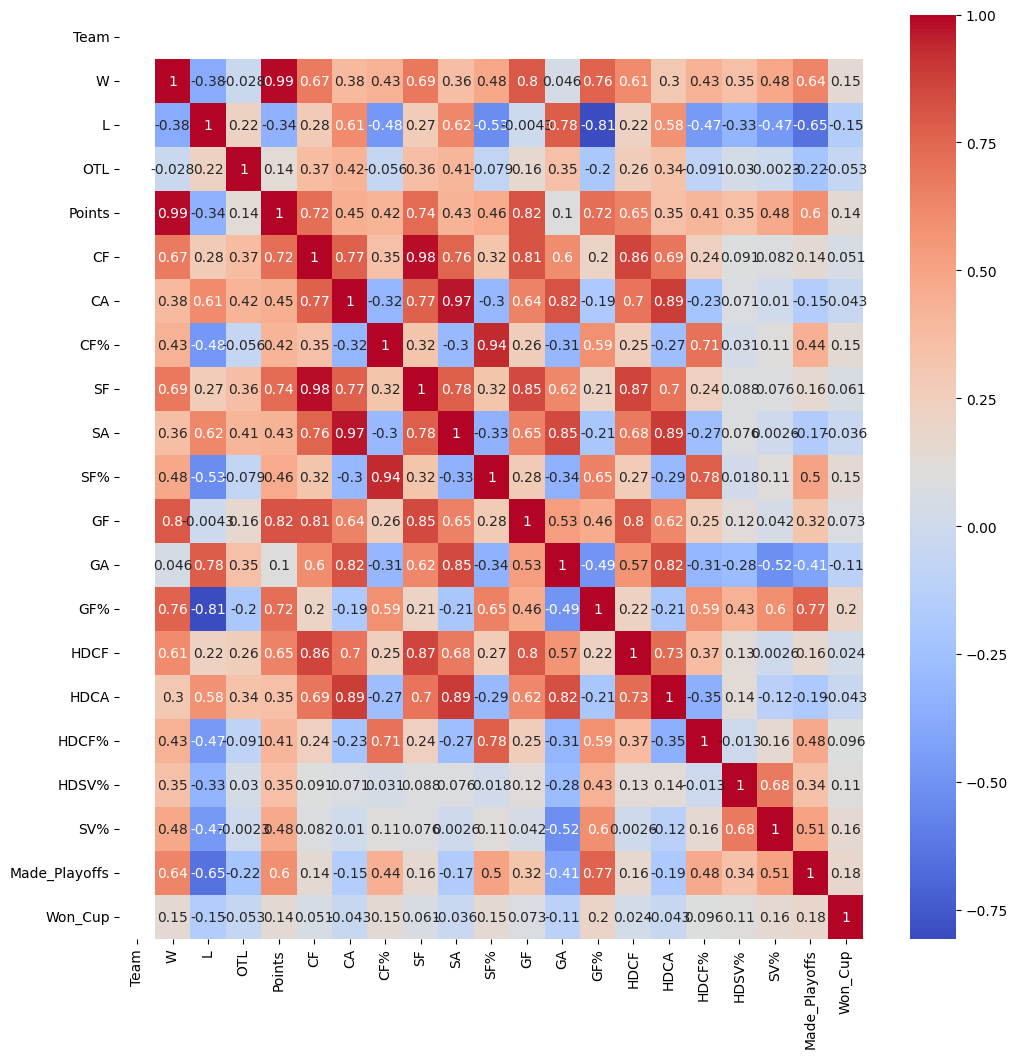

In [ ]:
#Create heatmap
for year in years:
    for col in dataframes[f'regular_season_data_{year}'].columns:
        dataframes[f'regular_season_data_{year}'][col] = pd.to_numeric(dataframes[f'regular_season_data_{year}'][col], errors='coerce')

correlation_matrix = pd.concat([dataframes[f'regular_season_data_{year}'][dataframes[f'regular_season_data_{year}'].columns] for year in years]).corr()

plt.figure(figsize = (12, 12))
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

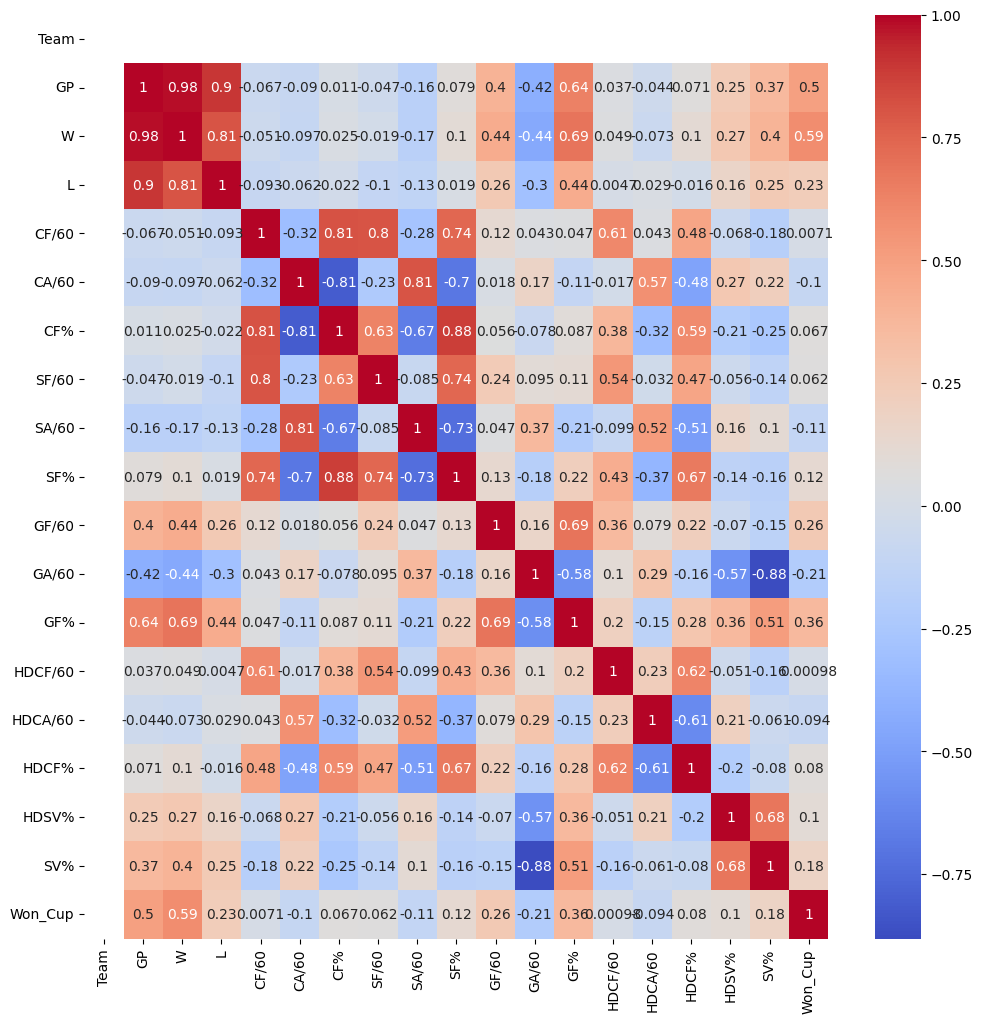

In [ ]:
# Create heatmap for postseason data
for year in years:
    for col in dataframes[f'postseason_data_{year}'].columns:
        dataframes[f'postseason_data_{year}'][col] = pd.to_numeric(dataframes[f'postseason_data_{year}'][col], errors='coerce')

correlation_matrix = pd.concat([dataframes[f'postseason_data_{year}'][dataframes[f'postseason_data_{year}'].columns] for year in years]).corr()

plt.figure(figsize = (12, 12))
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

***Linear Regression***

From the regular season heatmap, some of the significant Corsi For (CF), Goals For Percentage (GF%), and High Danger Chances For (HDCF) appear to be some of the higher correlated variables to the amount of Points a team got any given season.

**How much do these three offensive variables combined explain the variability in points?**

In [ ]:
# Import statsmodels
import statsmodels.api as sm
# Train models for each year
for name, data in dataframes.items():
    year = name.split('_')[-1]
    if name.startswith('regular_season_data'):
        df = data

        X = df[['CF', 'GF%', 'HDCF']]
        y = df['Points']

        X = sm.add_constant(X)

        model = sm.OLS(y, X).fit()

        print(f'Model for {year}:')
        print(model.summary())

Model for 2010:
                            OLS Regression Results                            
Dep. Variable:                 Points   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                     81.59
Date:                Wed, 13 Dec 2023   Prob (F-statistic):           2.36e-13
Time:                        15:50:48   Log-Likelihood:                -83.744
No. Observations:                  30   AIC:                             175.5
Df Residuals:                      26   BIC:                             181.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -80.4309     13.569    

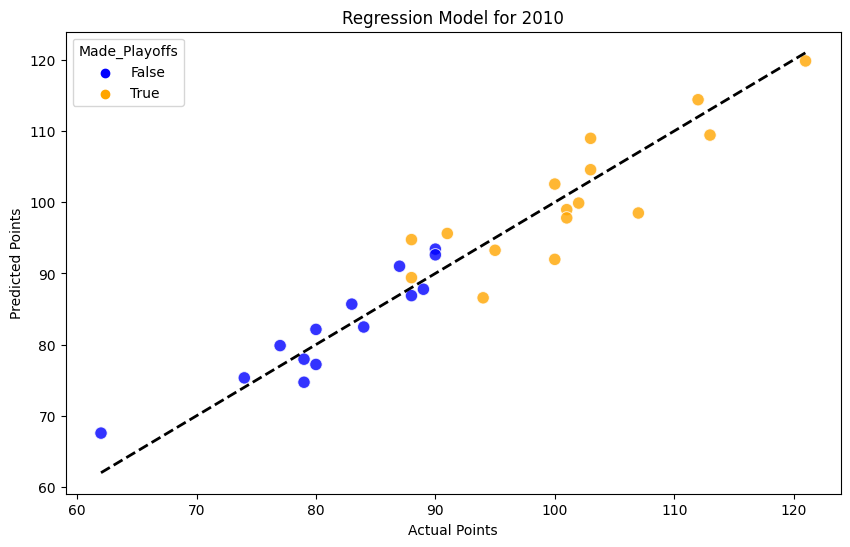

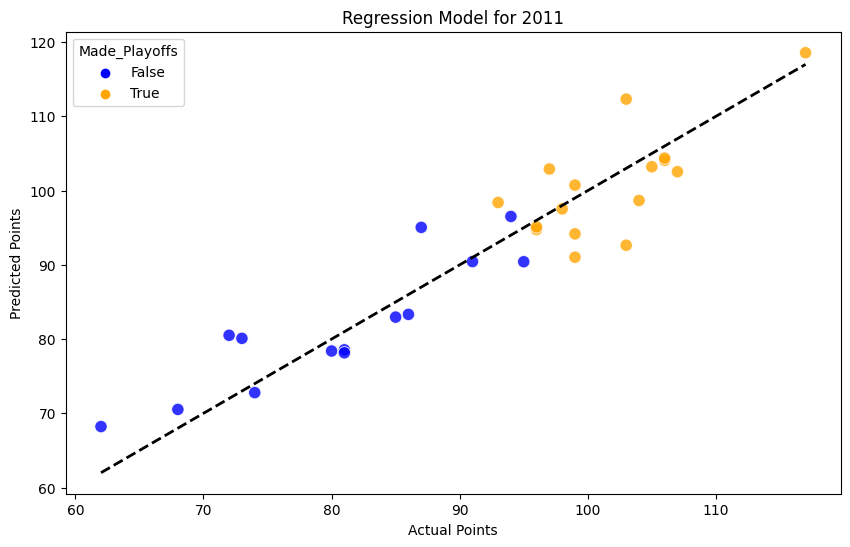

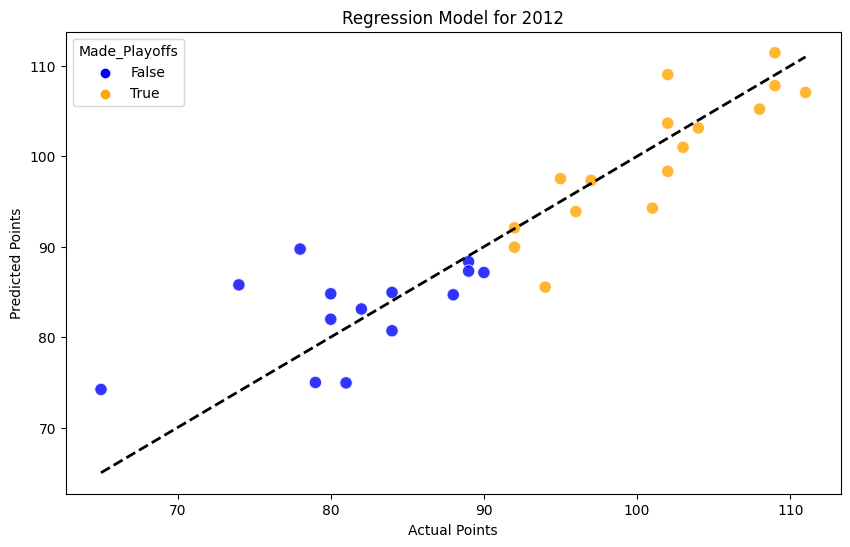

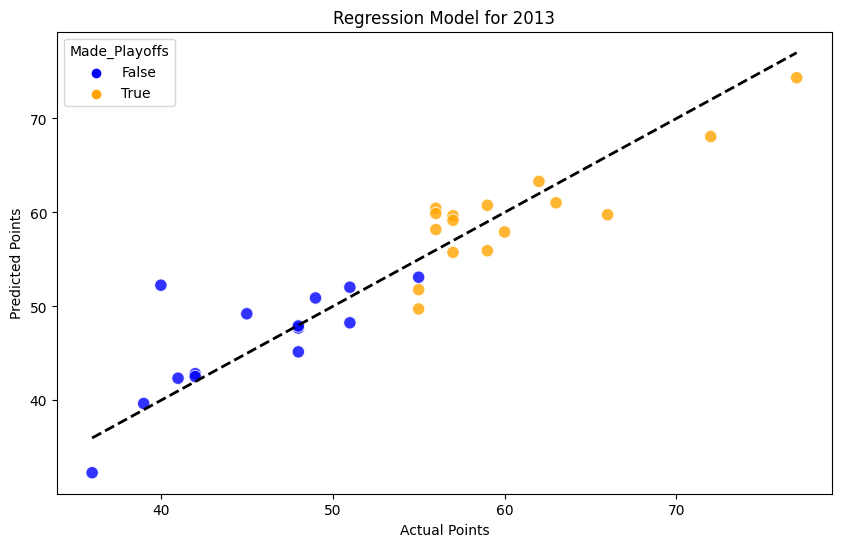

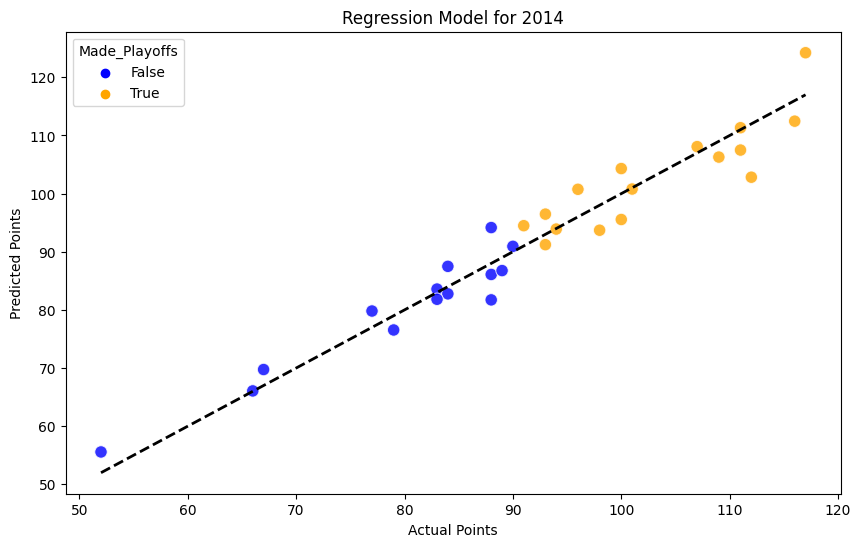

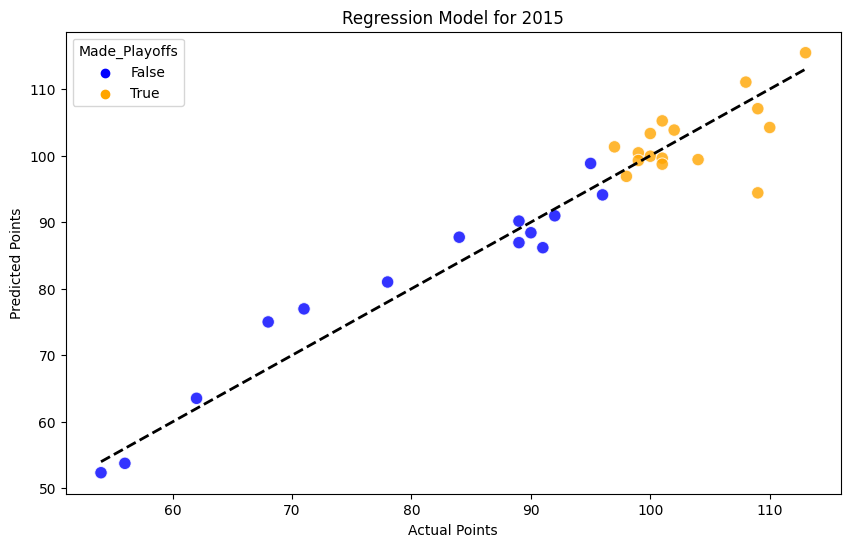

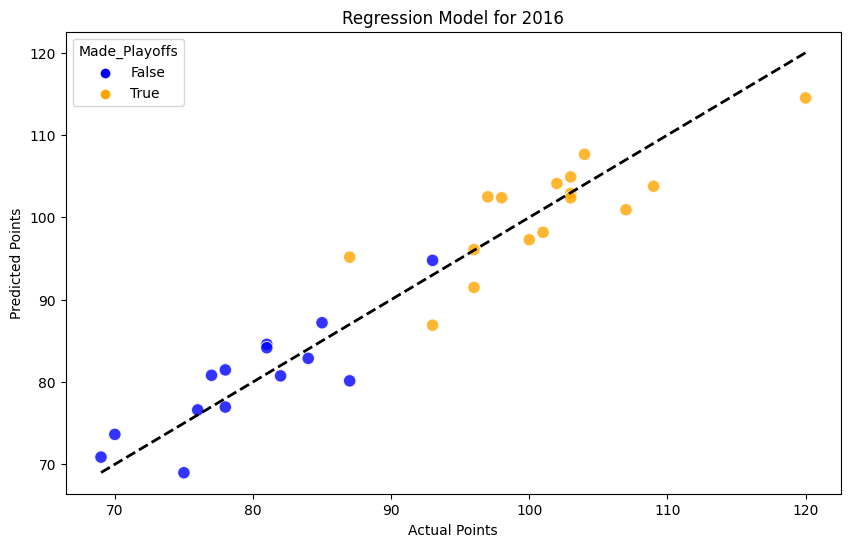

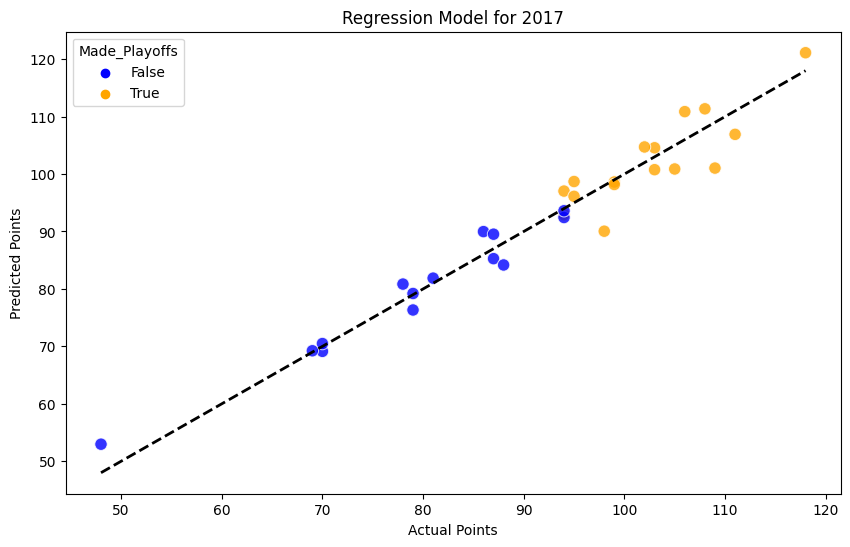

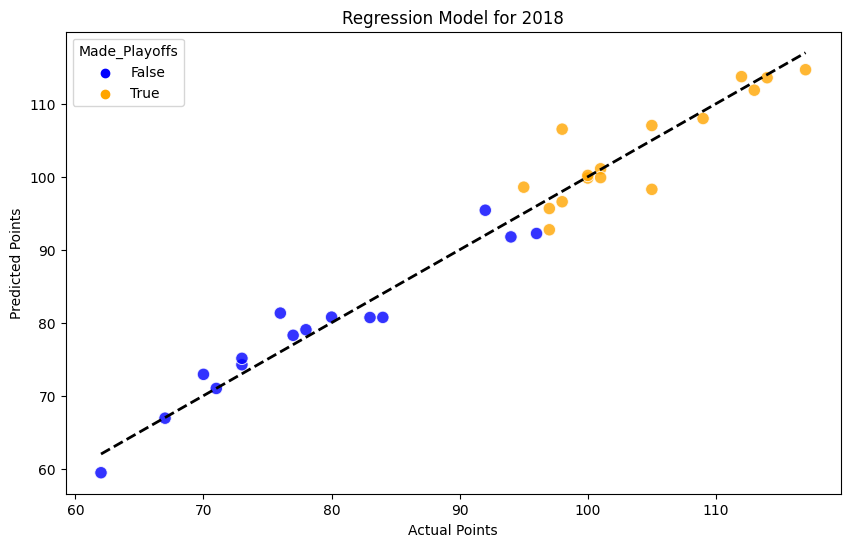

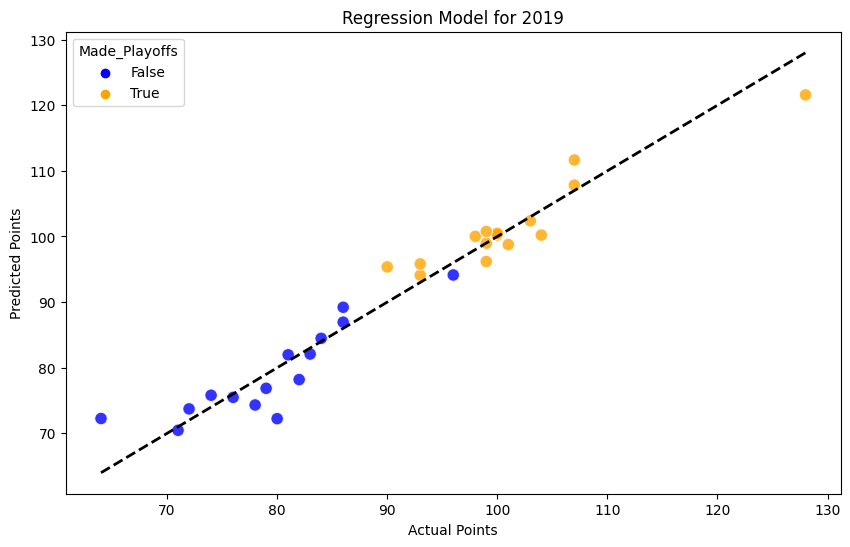

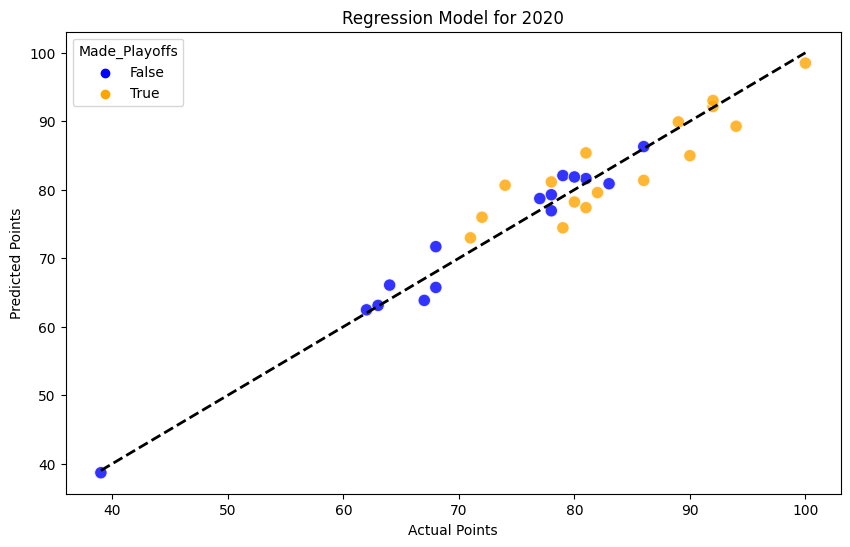

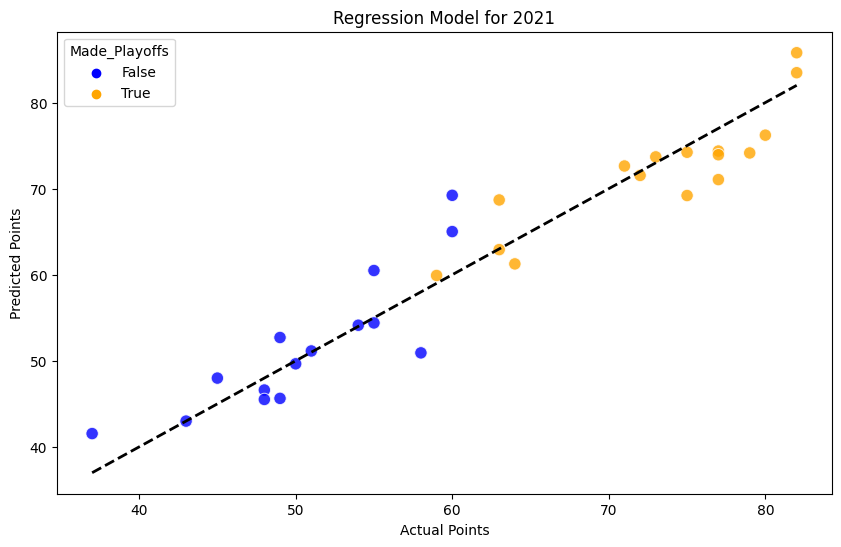

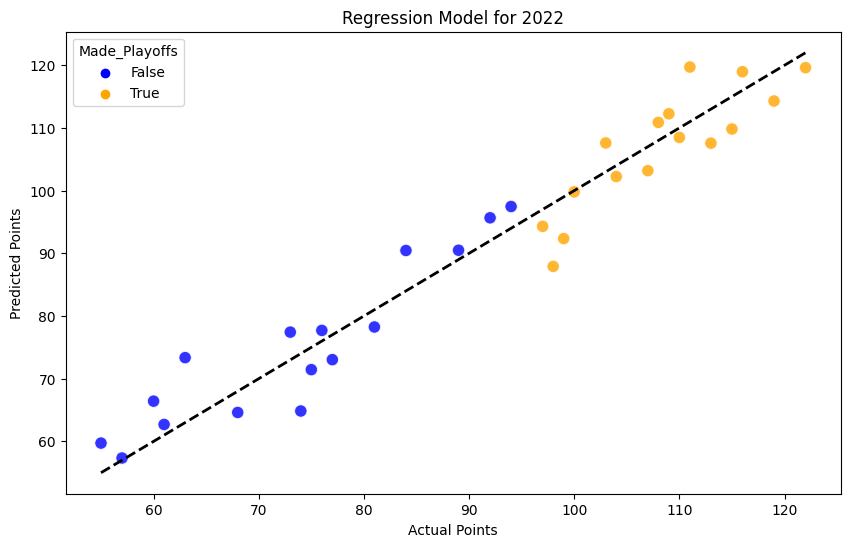

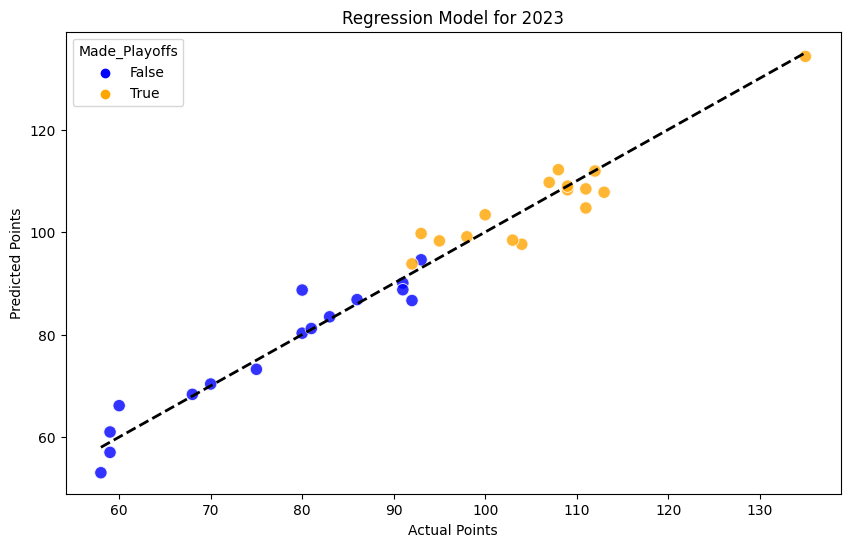

In [ ]:
for name, data in dataframes.items():
    year = name.split('_')[-1]
    if name.startswith('regular_season_data'):
        df = pd.DataFrame(data)
        X = df[['CF', 'GF%', 'HDCF']]
        y = df['Points']
        model = lm.LinearRegression()
        model.fit(X, y)
        y_pred = model.predict(X)

        plt.figure(figsize=(10, 6))
        sns.scatterplot(data = df, x = 'Points', y = y_pred, hue = 'Made_Playoffs', palette = {0: 'blue', 1:'orange'}, marker = 'o', s = 80, alpha = 0.8)

        plt.plot([df['Points'].min(), df['Points'].max()], [df['Points'].min(), df['Points'].max()], 'k--', lw=2)

        plt.xlabel('Actual Points')
        plt.ylabel('Predicted Points'),
        plt.title(f'Regression Model for {year}')

        plt.show()

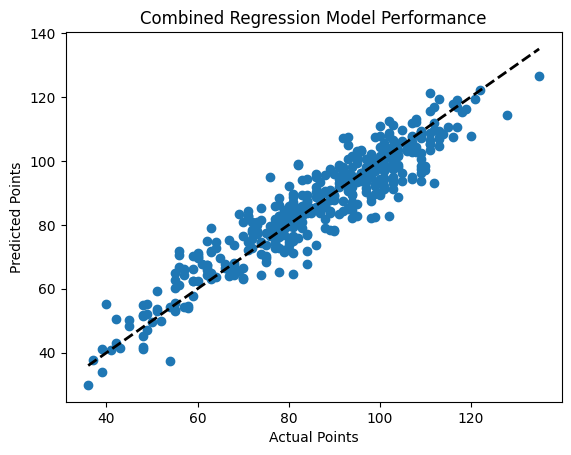

Combined Model:
Coefficients: [ 1.62004147e-02  2.47927083e+00 -1.89378738e-03]
Intercept: -106.81740851186254
R-squared: 0.8717541669397849
Mean Squared Error: 44.979055224748876


In [ ]:
from sklearn.metrics import r2_score, mean_squared_error

# Create a combined model
combined_df = pd.concat([pd.DataFrame(dataframes[f'regular_season_data_{year}']) for year in years])

X = combined_df[['CF', 'GF%', 'HDCF']]
y = combined_df['Points']

model = lm.LinearRegression()
model.fit(X, y)

y_pred = model.predict(X)
r_squared = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred)

# Visualize the combined regression model
plt.figure()
plt.scatter(y, y_pred)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual Points')
plt.ylabel('Predicted Points')
plt.title('Combined Regression Model Performance')
plt.show()

print('Combined Model:')
print('Coefficients:', model.coef_)
print('Intercept:', model.intercept_)
print('R-squared:', r_squared)
print('Mean Squared Error:', mse)

As expected from what I noticed in the heatmap, Corsi For, Goals For %, and High Danger Chances For are strongly correlated to the Points that a team has in the regular season as suggested by the high R-square value ***(87.175% of the variability explained by the model)***. The intercept (-106.817) in this case isn't really applicable as that would be a team that had zero offense/shots created across an entire season which is virtually impossible.  

******
******
******

**How would using defensive statistics explain the variability?**

In [38]:
# Train models for each year
for name, data in dataframes.items():
    year = name.split('_')[-1]
    if name.startswith('regular_season_data'):
        df = data

        X = df[['CA', 'HDSV%', 'SV%']]
        y = df['Points']

        X = sm.add_constant(X)

        model = sm.OLS(y, X).fit()

        print(f'Model for {year}:')
        print(model.summary())

Model for 2010:
                            OLS Regression Results                            
Dep. Variable:                 Points   R-squared:                       0.499
Model:                            OLS   Adj. R-squared:                  0.441
Method:                 Least Squares   F-statistic:                     8.618
Date:                Wed, 13 Dec 2023   Prob (F-statistic):           0.000387
Time:                        17:21:08   Log-Likelihood:                -108.54
No. Observations:                  30   AIC:                             225.1
Df Residuals:                      26   BIC:                             230.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -357.1136    221.283    

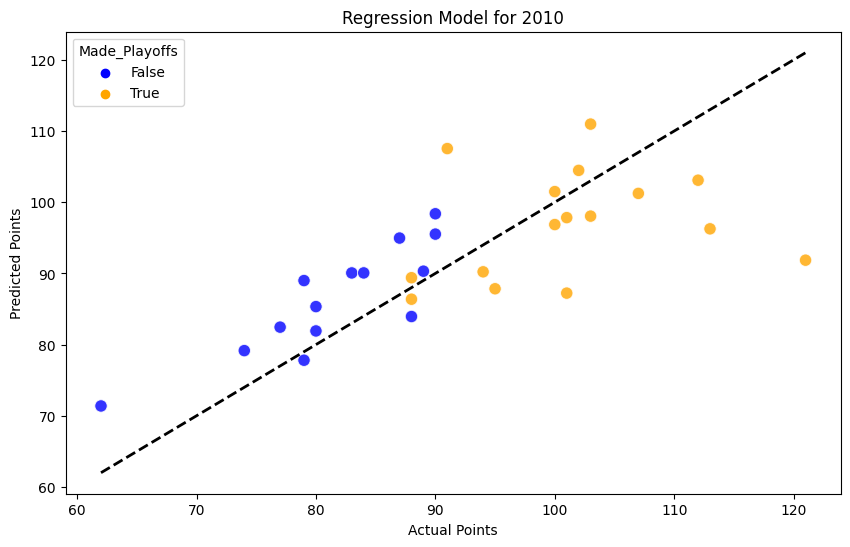

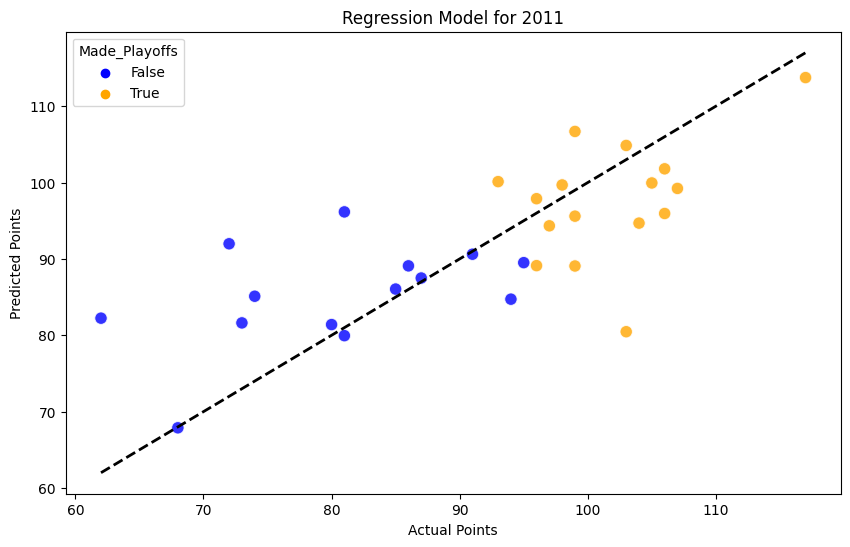

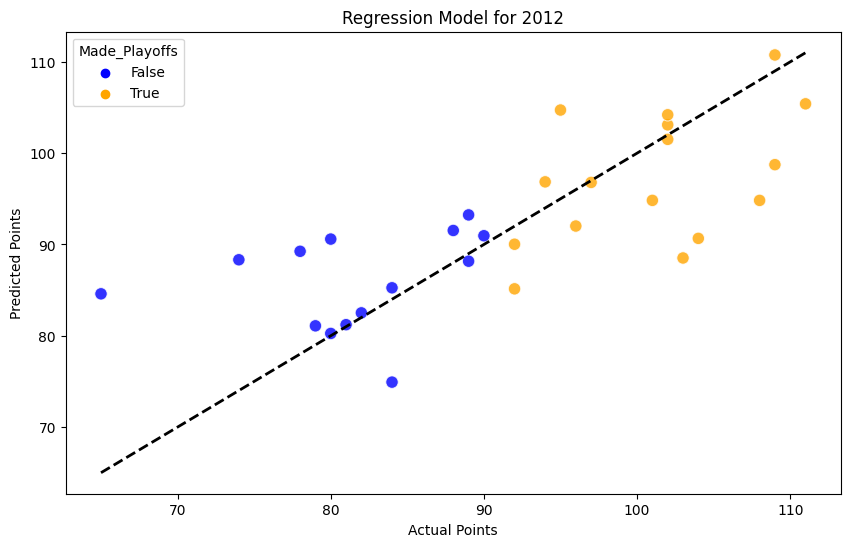

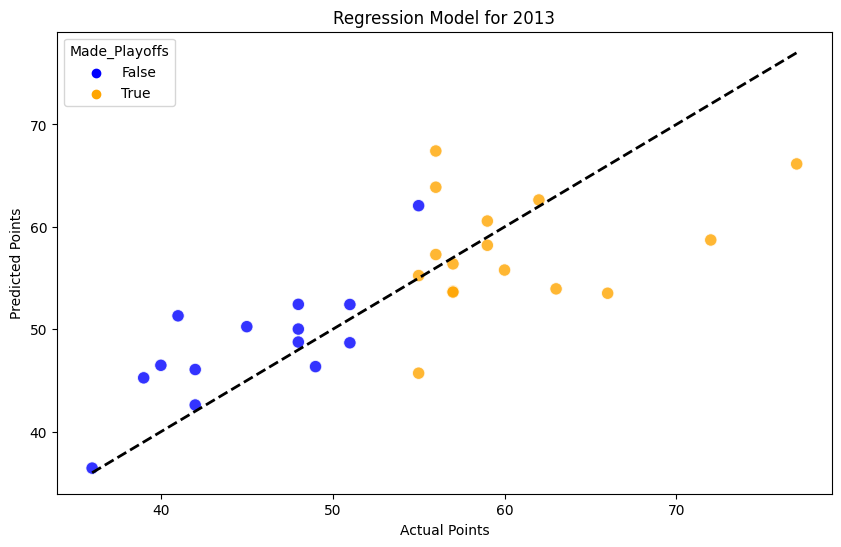

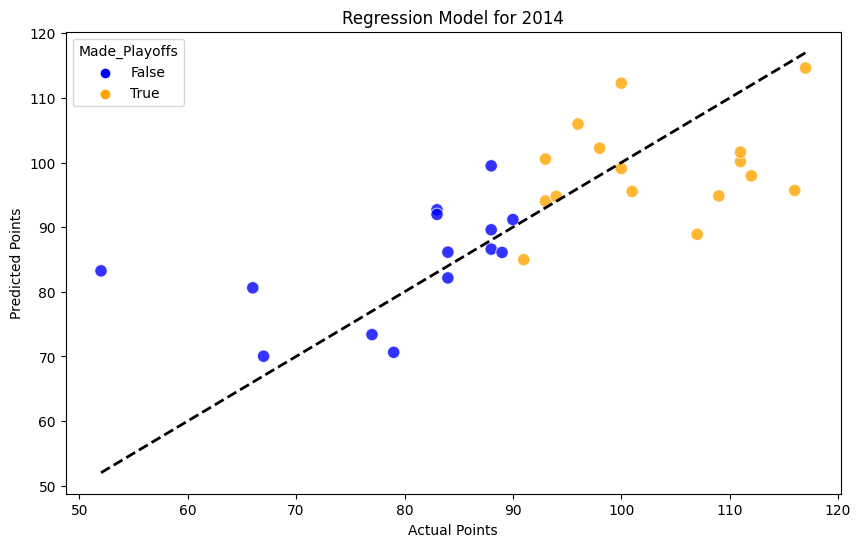

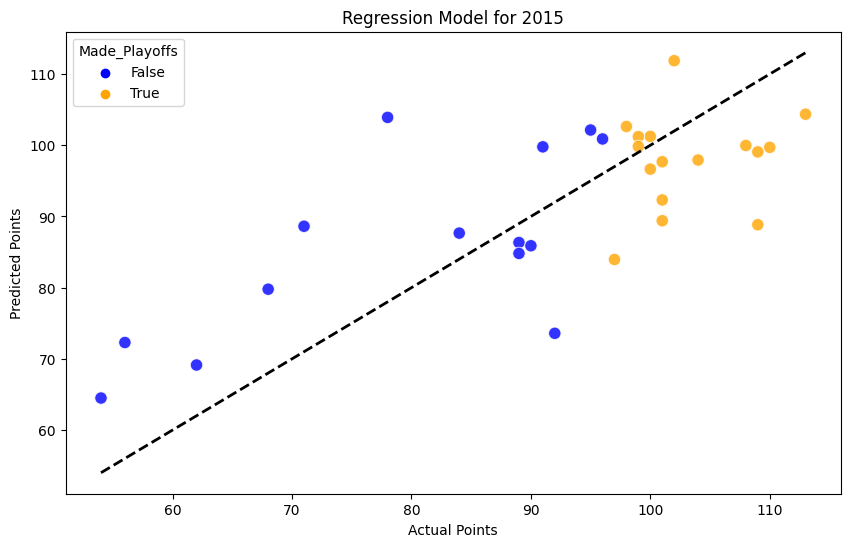

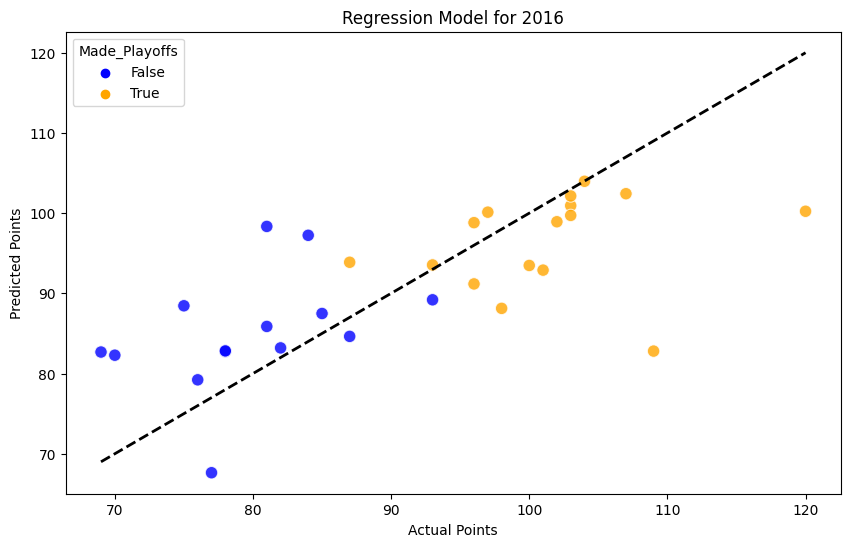

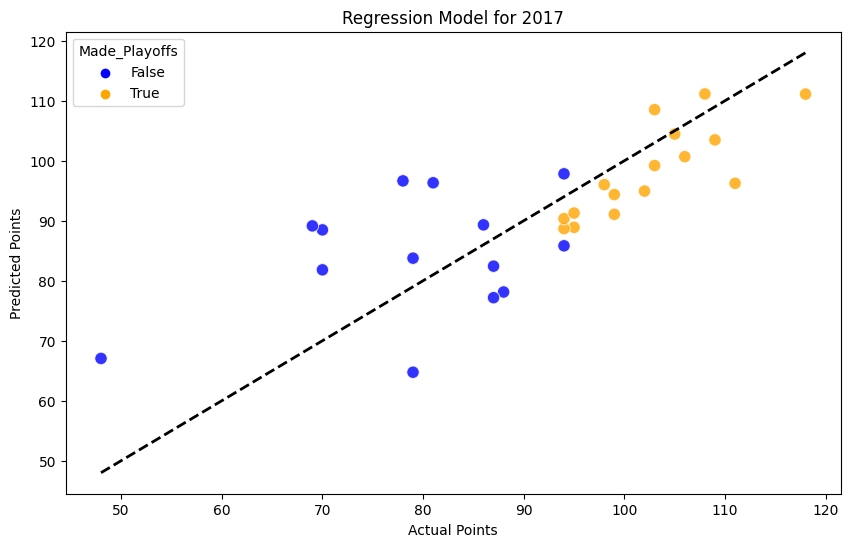

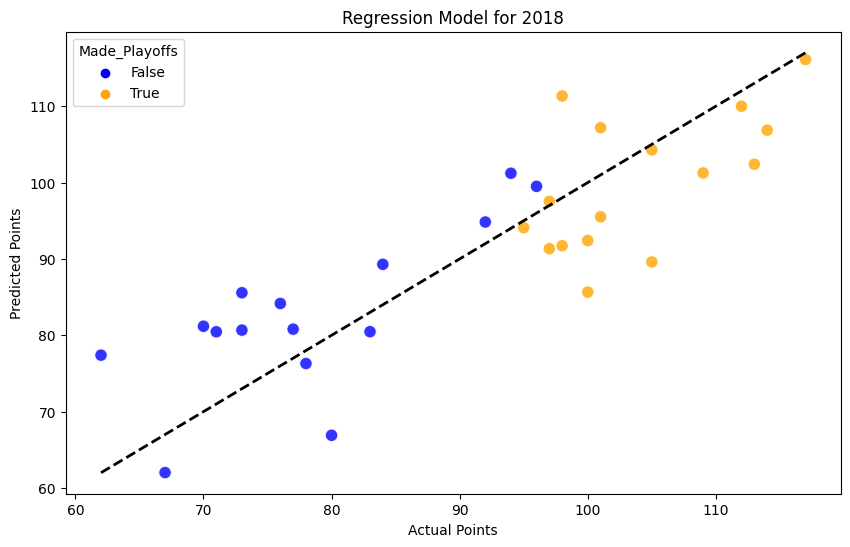

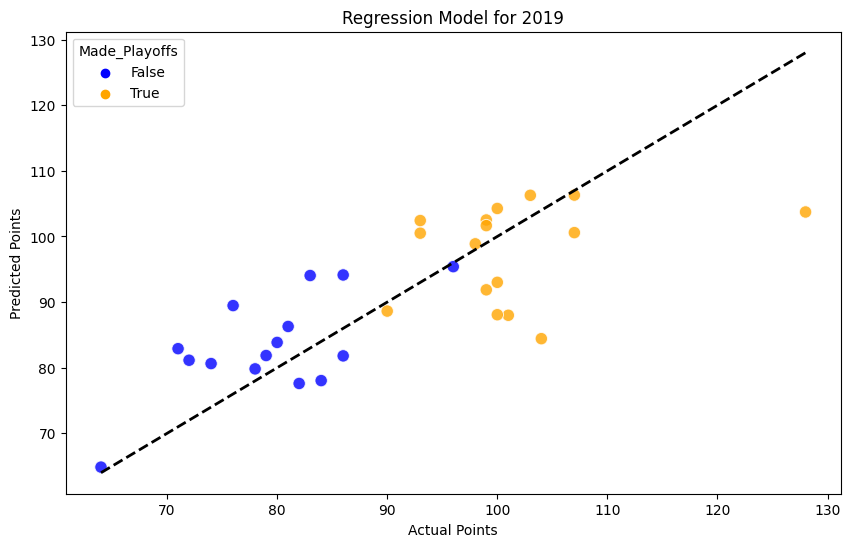

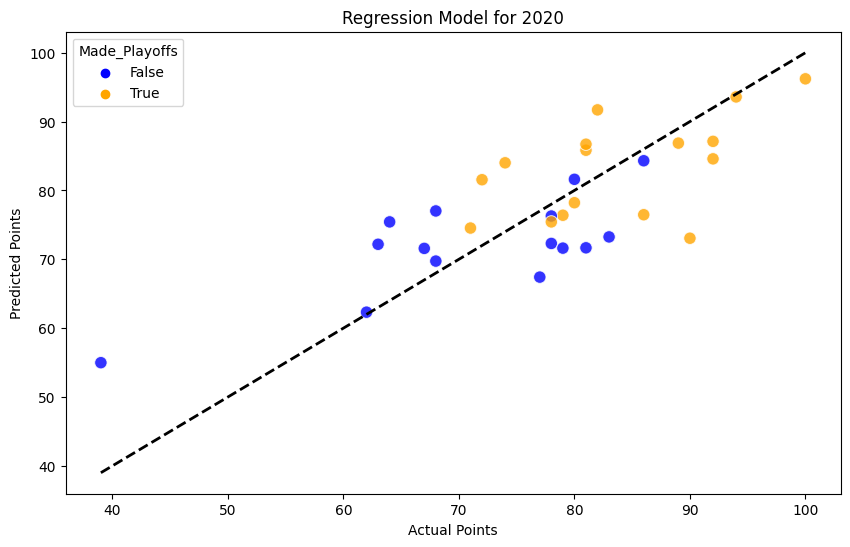

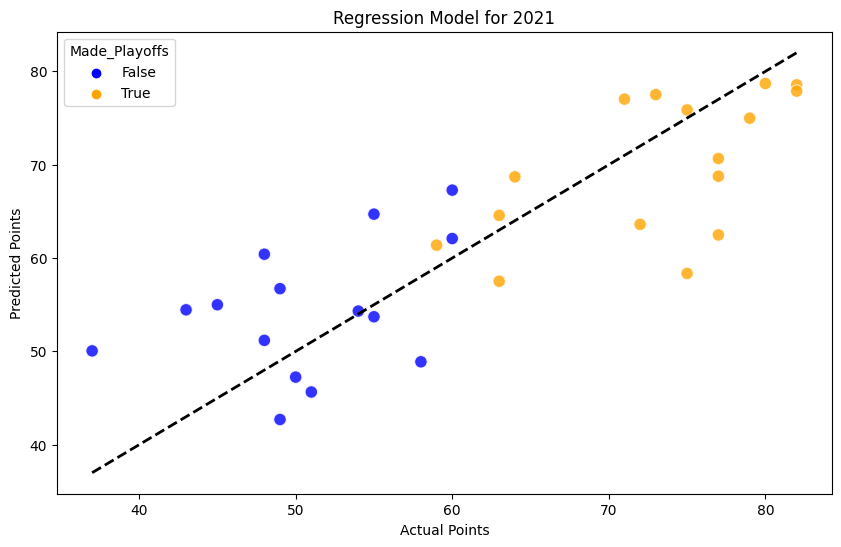

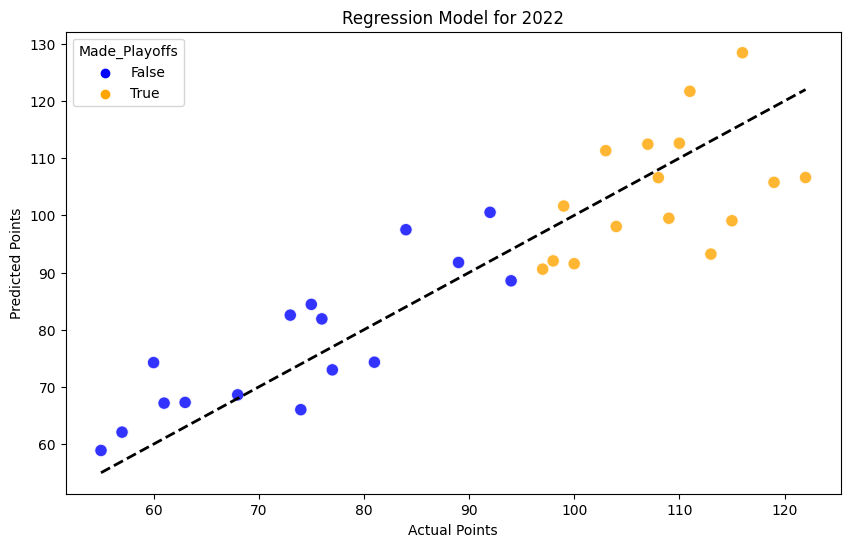

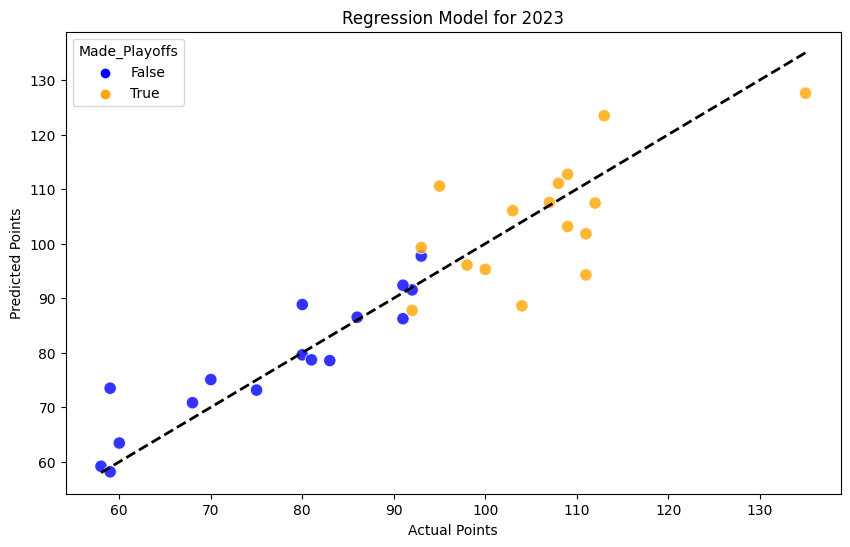

In [39]:
for name, data in dataframes.items():
    year = name.split('_')[-1]
    if name.startswith('regular_season_data'):
        df = pd.DataFrame(data)
        X = df[['CA', 'HDSV%', 'SV%']]
        y = df['Points']
        model = lm.LinearRegression()
        model.fit(X, y)
        y_pred = model.predict(X)

        plt.figure(figsize=(10, 6))
        sns.scatterplot(data = df, x = 'Points', y = y_pred, hue = 'Made_Playoffs', palette = {0: 'blue', 1:'orange'}, marker = 'o', s = 80, alpha = 0.8)

        plt.plot([df['Points'].min(), df['Points'].max()], [df['Points'].min(), df['Points'].max()], 'k--', lw=2)

        plt.xlabel('Actual Points')
        plt.ylabel('Predicted Points'),
        plt.title(f'Regression Model for {year}')

        plt.show()

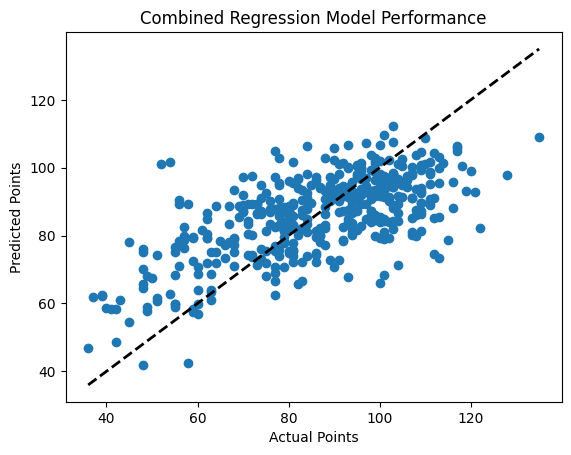

Combined Model:
Coefficients: [0.0118395  0.0257622  9.39580522]
Intercept: -820.1277873524673
R-squared: 0.4232383797051439
Mean Squared Error: 202.28487859389068


In [40]:
X = combined_df[['CA', 'HDSV%', 'SV%']]
y = combined_df['Points']

model = lm.LinearRegression()
model.fit(X, y)

y_pred = model.predict(X)
r_squared = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred)

# Visualize the combined regression model
plt.figure()
plt.scatter(y, y_pred)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual Points')
plt.ylabel('Predicted Points')
plt.title('Combined Regression Model Performance')
plt.show()

print('Combined Model:')
print('Coefficients:', model.coef_)
print('Intercept:', model.intercept_)
print('R-squared:', r_squared)
print('Mean Squared Error:', mse)

Unsuprisingly, the defensive/goaltending linear regression models don't explain the variability as effectively as the offensive ones did. However, one really interesting thing about this regression model is how it is a lot more effective on a season to season basis and takes a far drop when modeled on the combined dataframe (42.324%), compared to wide range from ~45% to ~85%, it is also interesting to see the variability explanibility change over the course of the seasons, getting stronger over time.

***Probit Regression***

The "Make_Playoffs" variable in the regular season data and the "Win_Cup" variable in the postseason data make the most sense as binary variables to have as dependent variables in seperate Probit regressions.

*Note: the "Win_Cup" variable created in the regular season data didn't seem appropriate to use as the cup is very dependent on postseason performance and the correlation was very low with any regular season variables especially due to only 1 of 30 to 32 teams having "Win_Cup" be True per season.*

***How do different regular season team statistics relate to making the playoffs?***

In [ ]:
y = combined_df['Made_Playoffs']
X = combined_df[['Points', 'SF%', 'GF%', 'HDCF%', 'HDSV%', 'SV%']]

X = sm.add_constant(X)

probit_model = sm.Probit(y, X)
probit_results = probit_model.fit()

print(probit_results.summary())

Optimization terminated successfully.
         Current function value: 0.210525
         Iterations 8
                          Probit Regression Results                           
Dep. Variable:          Made_Playoffs   No. Observations:                  428
Model:                         Probit   Df Residuals:                      421
Method:                           MLE   Df Model:                            6
Date:                Wed, 13 Dec 2023   Pseudo R-squ.:                  0.6958
Time:                        15:57:52   Log-Likelihood:                -90.105
converged:                       True   LL-Null:                       -296.20
Covariance Type:            nonrobust   LLR p-value:                 6.692e-86
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -74.7260     17.858     -4.185      0.000    -109.726     -39.726
Points         0.0133      0.

Due to the possibility of a complete quasi-separation, I figure the "Points" variable may not have been a good addition to the probit model.

***How do the team statistics relate to making the playoffs without the "Points" variable involved?***

In [ ]:
y = combined_df['Made_Playoffs']
X = combined_df[['SF%', 'GF%', 'HDCF%', 'HDSV%', 'SV%']]

X = sm.add_constant(X)

probit_model = sm.Probit(y, X)
probit_results = probit_model.fit()

print(probit_results.summary())

Optimization terminated successfully.
         Current function value: 0.213613
         Iterations 8
                          Probit Regression Results                           
Dep. Variable:          Made_Playoffs   No. Observations:                  428
Model:                         Probit   Df Residuals:                      422
Method:                           MLE   Df Model:                            5
Date:                Wed, 13 Dec 2023   Pseudo R-squ.:                  0.6913
Time:                        15:58:00   Log-Likelihood:                -91.426
converged:                       True   LL-Null:                       -296.20
Covariance Type:            nonrobust   LLR p-value:                 2.598e-86
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -79.5979     17.769     -4.480      0.000    -114.425     -44.771
SF%            0.0528      0.

Since the quasi-separation is still present, "Points" doesn't appear to be causing the issue. I think that removing the "GF%" could potentially solve the issue because of the incredibly high z-score as well as thinking logistically about what the statistic is measuring.

***How does removing the "GF%" variable affect the probit regression model?***

In [ ]:
y = combined_df['Made_Playoffs']
X = combined_df[['Points', 'SF%', 'HDCF%', 'HDSV%', 'SV%']]

X = sm.add_constant(X)

probit_model = sm.Probit(y, X)
probit_results = probit_model.fit()

print(probit_results.summary())

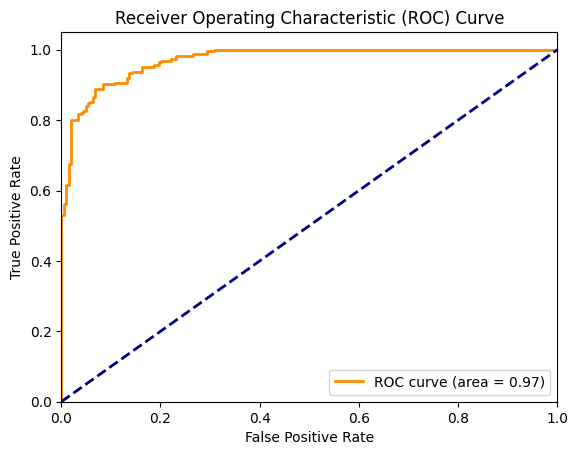

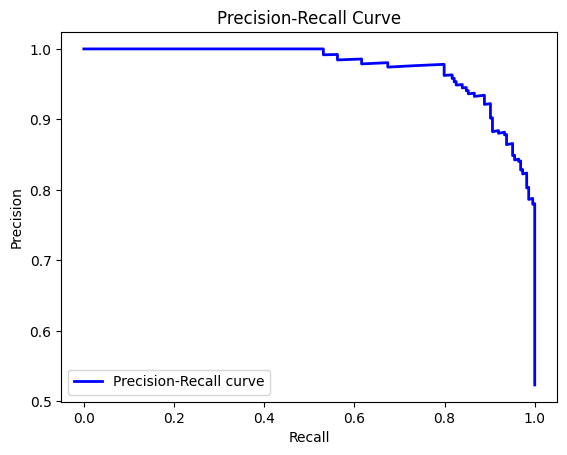

Area under the PR curve: 0.9740943885582592


In [18]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(probit_results.model.endog, probit_results.fittedvalues)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Calculate precision-recall curve
precision, recall, _ = precision_recall_curve(probit_results.model.endog, probit_results.fittedvalues)
pr_auc = auc(recall, precision)

# Plot precision-recall curve
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()
print("Area under the PR curve:", pr_auc)

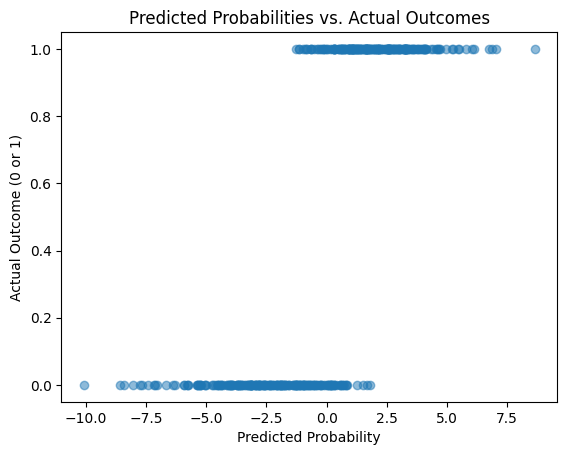

In [19]:
plt.figure()
plt.scatter(probit_results.fittedvalues, probit_results.model.endog, alpha=0.5)
plt.xlabel('Predicted Probability')
plt.ylabel('Actual Outcome (0 or 1)')
plt.title('Predicted Probabilities vs. Actual Outcomes')
plt.show()

Overall, the Probit model exhibits strong performance as shown by the high Area Under the ROC Curve of 0.93, indicating that the model is proficient at distinguishing between the binary of making the playoffs or not.


The model's predictive power is on display in the scatter plot, as the alignment exhibits how closely the model's predictions match the observed outcomes.

The Precision-Recall Curve also supports the strength of the Probit model's ability to accurately predict whether a team makes the playoffs or not based on the independent variables.

In conclusion, the Probit model demonstrates effectiveness in capturing the underlying patterns in the data and predicting playoff outcomes based on them. The visualizations also work to enhance our understanding of the model's strengths and limitations. This comprehensive analysis validates the model's performance.

******
******
******
***Out of curiousity, how does the model perform without both "GF%" and "Points"?***



In [ ]:
y = combined_df['Made_Playoffs']
X = combined_df[['SF%', 'HDCF%', 'HDSV%', 'SV%']]

X = sm.add_constant(X)

probit_model = sm.Probit(y, X)
probit_results = probit_model.fit()

print(probit_results.summary())

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(probit_results.model.endog, probit_results.fittedvalues)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Calculate precision-recall curve
precision, recall, _ = precision_recall_curve(probit_results.model.endog, probit_results.fittedvalues)
pr_auc = auc(recall, precision)

# Plot precision-recall curve
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()
print("Area under the PR curve:", pr_auc)

plt.figure()
plt.scatter(probit_results.fittedvalues, probit_results.model.endog, alpha=0.5)
plt.xlabel('Predicted Probability')
plt.ylabel('Actual Outcome (0 or 1)')
plt.title('Predicted Probabilities vs. Actual Outcomes')
plt.show()

***How effective is a probit regression at predicting the Stanley Cup Champions based on postseason team statistics?***

In [20]:
# Create a combined dataframe with all of the postseason data
pscombined_df = pd.concat([pd.DataFrame(dataframes[f'postseason_data_{year}']) for year in years])

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

y = pscombined_df['Won_Cup']
X = pscombined_df[['CF/60', 'SF%', 'HDCF/60', 'HDCF%', 'HDSV%', 'SV%']]

X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

probit_model = sm.Probit(y_train, X_train)
probit_result = probit_model.fit()

print(probit_result.summary())

y_pred = probit_result.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

print("Classification Report:\n", classification_report(y_test, y_pred_binary))

Optimization terminated successfully.
         Current function value: 0.184819
         Iterations 9
                          Probit Regression Results                           
Dep. Variable:                Won_Cup   No. Observations:                  185
Model:                         Probit   Df Residuals:                      178
Method:                           MLE   Df Model:                            6
Date:                Wed, 13 Dec 2023   Pseudo R-squ.:                  0.2304
Time:                        16:56:53   Log-Likelihood:                -34.192
converged:                       True   LL-Null:                       -44.428
Covariance Type:            nonrobust   LLR p-value:                  0.002281
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -53.6961     17.593     -3.052      0.002     -88.177     -19.215
CF/60         -0.0694      0.

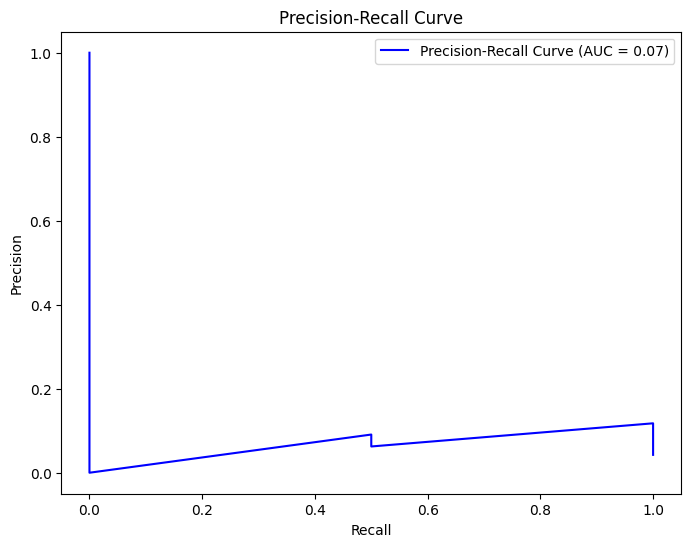

In [26]:
y_pred = probit_result.predict(X_test)

# Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_pred)

# Area under the curve (AUC) for Precision-Recall
pr_auc = auc(recall, precision)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Precision-Recall Curve (AUC = {pr_auc:.2f})', color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

The classification report and Precision-Recall Curve display that there is some level of sampling change that needs to be done due to the model's struggles to predict True Positives due to only 1 team winning the cup every season.

A technique that can be used to work around this class imbalance is Under Sampling, since the positive (Win the Cup) case is a huge minority compared to the negative (Not Winning the Cup).

In [31]:
from imblearn.under_sampling import RandomUnderSampler

# Assuming pscombined_df is your DataFrame
y = pscombined_df['Won_Cup']
X = pscombined_df[['CF/60', 'SF%', 'HDCF/60', 'HDCF%', 'HDSV%', 'SV%']]

# Add a constant term to the independent variables
X = sm.add_constant(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Undersample the majority class in the training set
undersampler = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

# Fit the Probit regression model on the resampled training data
probit_model = sm.Probit(y_train_resampled, X_train_resampled)
probit_result = probit_model.fit()
print(probit_result.summary())

Optimization terminated successfully.
         Current function value: 0.357866
         Iterations 8
                          Probit Regression Results                           
Dep. Variable:                Won_Cup   No. Observations:                   24
Model:                         Probit   Df Residuals:                       17
Method:                           MLE   Df Model:                            6
Date:                Wed, 13 Dec 2023   Pseudo R-squ.:                  0.4837
Time:                        17:10:27   Log-Likelihood:                -8.5888
converged:                       True   LL-Null:                       -16.636
Covariance Type:            nonrobust   LLR p-value:                   0.01326
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -161.2741     82.505     -1.955      0.051    -322.981       0.433
CF/60         -0.3153      0.

After under sampling, the model improves in it's ability to explain the variance, as well as the statistical significance of the variables. However, the model would still need better more advanced engineering to strengthen it's ability to predict the cup winner due to complexity of the problem that I'm attempting to solve.